In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

# 6.1

Load the COMPAS data, apply ProPublica's inclusion criteria, and summarize the analysis sample.

Confidence: 8

In [ ]:
# Load COMPAS data from ProPublica GitHub
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
raw_data = pd.read_csv(url)

Variables used in analysis:
  - age
  - age_cat
  - c_charge_degree
  - race
  - sex
  - priors_count
  - days_b_screening_arrest
  - decile_score
  - score_text
  - two_year_recid
  - is_recid
  - c_jail_in
  - c_jail_out


In [ ]:
# Sample size before filtering
n_before = len(raw_data)

df = raw_data[
    (raw_data["days_b_screening_arrest"] >= -30) &
    (raw_data["days_b_screening_arrest"] <= 30) &
    (raw_data["is_recid"] != -1) &
    (raw_data["c_charge_degree"] != "O") &
    (raw_data["score_text"] != "N/A")
].copy()

n_after = len(df)
pct_retained = 100 * n_after / n_before

print(f"\nSample size after filtering: {n_after}")
print(f"Percentage of original sample retained: {pct_retained:.2f}%")

Sample size before filtering: 7214

Sample size after filtering: 6172
Percentage of original sample retained: 85.56%


In [3]:
# Summarize the analysis sample

print("=== Age category ===")
age_counts = df["age_cat"].value_counts()
age_pct = df["age_cat"].value_counts(normalize=True) * 100
for cat in age_counts.index:
    print(f"  {cat}: {age_counts[cat]} ({age_pct[cat]:.1f}%)")

print("\n=== Race ===")
race_counts = df["race"].value_counts()
race_pct = df["race"].value_counts(normalize=True) * 100
for cat in race_counts.index:
    print(f"  {cat}: {race_counts[cat]} ({race_pct[cat]:.1f}%)")

print("\n=== Sex ===")
sex_counts = df["sex"].value_counts()
sex_pct = df["sex"].value_counts(normalize=True) * 100
for cat in sex_counts.index:
    print(f"  {cat}: {sex_counts[cat]} ({sex_pct[cat]:.1f}%)")

print("\n=== COMPAS score (Low / Medium / High) ===")
score_counts = df["score_text"].value_counts()
score_pct = df["score_text"].value_counts(normalize=True) * 100
for cat in ["Low", "Medium", "High"]:
    if cat in score_counts.index:
        print(f"  {cat}: {score_counts[cat]} ({score_pct[cat]:.1f}%)")

=== Age category ===
  25 - 45: 3532 (57.2%)
  Less than 25: 1347 (21.8%)
  Greater than 45: 1293 (20.9%)

=== Race ===
  African-American: 3175 (51.4%)
  Caucasian: 2103 (34.1%)
  Hispanic: 509 (8.2%)
  Other: 343 (5.6%)
  Asian: 31 (0.5%)
  Native American: 11 (0.2%)

=== Sex ===
  Male: 4997 (81.0%)
  Female: 1175 (19.0%)

=== COMPAS score (Low / Medium / High) ===
  Low: 3421 (55.4%)
  Medium: 1607 (26.0%)
  High: 1144 (18.5%)


In [4]:
# Cross-tabulation: Sex by Race
print("Cross-tabulation: Sex by Race")
print(pd.crosstab(df["sex"], df["race"]))

Cross-tabulation: Sex by Race
race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285


# 6.2 Pipeline: Analysis (confidence 8)

Test whether COMPAS scores differ by race and age; assess predictive accuracy; quantify bias.

Confidence: 8

In [ ]:
# Outcome: Medium/High (1) vs Low (0)
df["score_med_high"] = (df["score_text"].isin(["Medium", "High"])).astype(int)

# Charge type: Felony (F) vs Misdemeanor (M)
df["charge_felony"] = df["c_charge_degree"].str[0].map({"F": 1, "M": 0}).fillna(0)

# get_dummies with drop_first=True drops first column (alphabetically)
X_design = pd.get_dummies(
    df[["priors_count", "charge_felony", "two_year_recid", "sex", "age_cat", "race"]],
    columns=["sex", "age_cat", "race"],
    drop_first=True
)

# Infer reference (dropped) from data: first alphabetically per variable
ref_sex = min(df["sex"].unique())
ref_age = min(df["age_cat"].unique())
ref_race = min(df["race"].unique())

feature_names = X_design.columns.tolist()
X = X_design.values
y = df["score_med_high"].values

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X, y)

# Print coefficients (log-odds) and odds ratios
print(f"Logistic regression: Medium/High vs Low (reference: {ref_sex}, {ref_age}, {ref_race})")
print("-" * 55)
print(f"{'Feature':<20} {'Coef':>10} {'Odds Ratio':>12}")
print("-" * 55)
print(f"{'intercept':<20} {model.intercept_[0]:>10.4f} {np.exp(model.intercept_[0]):>12.4f}")
for name, coef in zip(feature_names, model.coef_[0]):
    print(f"{name:<20} {coef:>10.4f} {np.exp(coef):>12.4f}")

Logistic regression: Medium/High vs Low (reference: Female, 25 - 45, African-American)
-------------------------------------------------------
Feature                    Coef   Odds Ratio
-------------------------------------------------------
intercept               -1.1415       0.3194
priors_count             0.2685       1.3080
charge_felony            0.3099       1.3633
two_year_recid           0.6828       1.9795
sex_Male                -0.2169       0.8050
age_cat_Greater than 45    -1.3443       0.2607
age_cat_Less than 25     1.3018       3.6759
race_Asian              -0.6582       0.5178
race_Caucasian          -0.4734       0.6229
race_Hispanic           -0.8908       0.4103
race_Native American     0.3945       1.4837
race_Other              -1.2703       0.2808


In [7]:
# Interpret key coefficients (odds ratios)
coef_dict = dict(zip(feature_names, model.coef_[0]))

# Black vs white: invert if Caucasian is in model (ref=African-American) else use African-American coef
if any("Caucasian" in c for c in feature_names):
    race_col = [c for c in feature_names if "Caucasian" in c][0]
    or_black_vs_white = 1 / np.exp(coef_dict[race_col])  # white vs black -> invert for black vs white
else:
    race_col = [c for c in feature_names if "African" in c][0]
    or_black_vs_white = np.exp(coef_dict[race_col])

age_less_col = [c for c in feature_names if "Less than 25" in c][0]
age_greater_col = [c for c in feature_names if "Greater than 45" in c][0]

print("Interpretation:")
print("  - Black vs white: African-American defendants have", or_black_vs_white.round(2), "x odds of Medium/High score (vs Low) when other factors are equal.")
print("  - Young vs middle-aged: Less than 25 have", np.exp(coef_dict[age_less_col]).round(2), "x odds vs", ref_age, "reference.")
print("  - Older vs middle-aged: Greater than 45 have", np.exp(coef_dict[age_greater_col]).round(2), "x odds vs", ref_age, "reference.")

Interpretation:
  - Black vs white: African-American defendants have 1.61 x odds of Medium/High score (vs Low) when other factors are equal.
  - Young vs middle-aged: Less than 25 have 3.68 x odds vs 25 - 45 reference.
  - Older vs middle-aged: Greater than 45 have 0.26 x odds vs 25 - 45 reference.


In [ ]:
# Cox proportional hazards model: COMPAS decile_score predicting recidivism
# Outcome: time to recidivism (start, end, event)

# Survival data: duration = end - start, event = 1 if recidivated
df_cox = df[["start", "end", "event", "decile_score"]].copy()
df_cox["duration"] = df_cox["end"] - df_cox["start"]
df_cox = df_cox[df_cox["duration"] > 0]  # Cox requires positive duration

cph = CoxPHFitter()
cph.fit(df_cox[["duration", "event", "decile_score"]], duration_col="duration", event_col="event")
print("Cox model: COMPAS decile_score predicting recidivism")
print(cph.summary)

# Concordance (C-index): how well decile_score ranks risk
c_index = concordance_index(df_cox["duration"], df_cox["decile_score"], df_cox["event"])
print(f"\nConcordance index (C): {c_index:.4f}")
print("(Higher decile_score = higher predicted risk; C measures ranking accuracy)")

Cox model: COMPAS decile_score predicting recidivism
                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
decile_score  0.19369    1.21372  0.007136        0.179704        0.207677   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
decile_score             1.196863             1.230815     0.0  27.14273   

                          p    -log2(p)  
covariate                                
decile_score  3.085272e-162  536.526954  

Concordance index (C): 0.3426
(Higher decile_score = higher predicted risk; C measures ranking accuracy)


In [10]:
# Quantify directions of bias by race
# Overprediction: high-score (Med/High) defendants who did NOT reoffend
# Underprediction: low-score defendants who DID reoffend

# By race (focus on African-American and Caucasian per ProPublica)
races = ["African-American", "Caucasian"]
print("Overprediction: % of High/Medium-score defendants who did NOT reoffend, by race")
print("-" * 60)
for r in races:
    sub = df[df["race"] == r]
    high_sub = sub[sub["score_text"].isin(["Medium", "High"])]
    n_high = len(high_sub)
    n_overpred = len(high_sub[high_sub["two_year_recid"] == 0])
    pct = 100 * n_overpred / n_high if n_high > 0 else 0
    print(f"  {r}: {n_overpred}/{n_high} = {pct:.1f}%")

print("\nUnderprediction: % of Low-score defendants who DID reoffend, by race")
print("-" * 60)
for r in races:
    sub = df[df["race"] == r]
    low_sub = sub[sub["score_text"] == "Low"]
    n_low = len(low_sub)
    n_underpred = len(low_sub[low_sub["two_year_recid"] == 1])
    pct = 100 * n_underpred / n_low if n_low > 0 else 0
    print(f"  {r}: {n_underpred}/{n_low} = {pct:.1f}%")

Overprediction: % of High/Medium-score defendants who did NOT reoffend, by race
------------------------------------------------------------
  African-American: 641/1829 = 35.0%
  Caucasian: 282/696 = 40.5%

Underprediction: % of Low-score defendants who DID reoffend, by race
------------------------------------------------------------
  African-American: 473/1346 = 35.1%
  Caucasian: 408/1407 = 29.0%


# 6.3 Pipeline: Visualization

Bar charts for demographics and COMPAS score; score distribution by race; directions of bias.

Confidence: 8

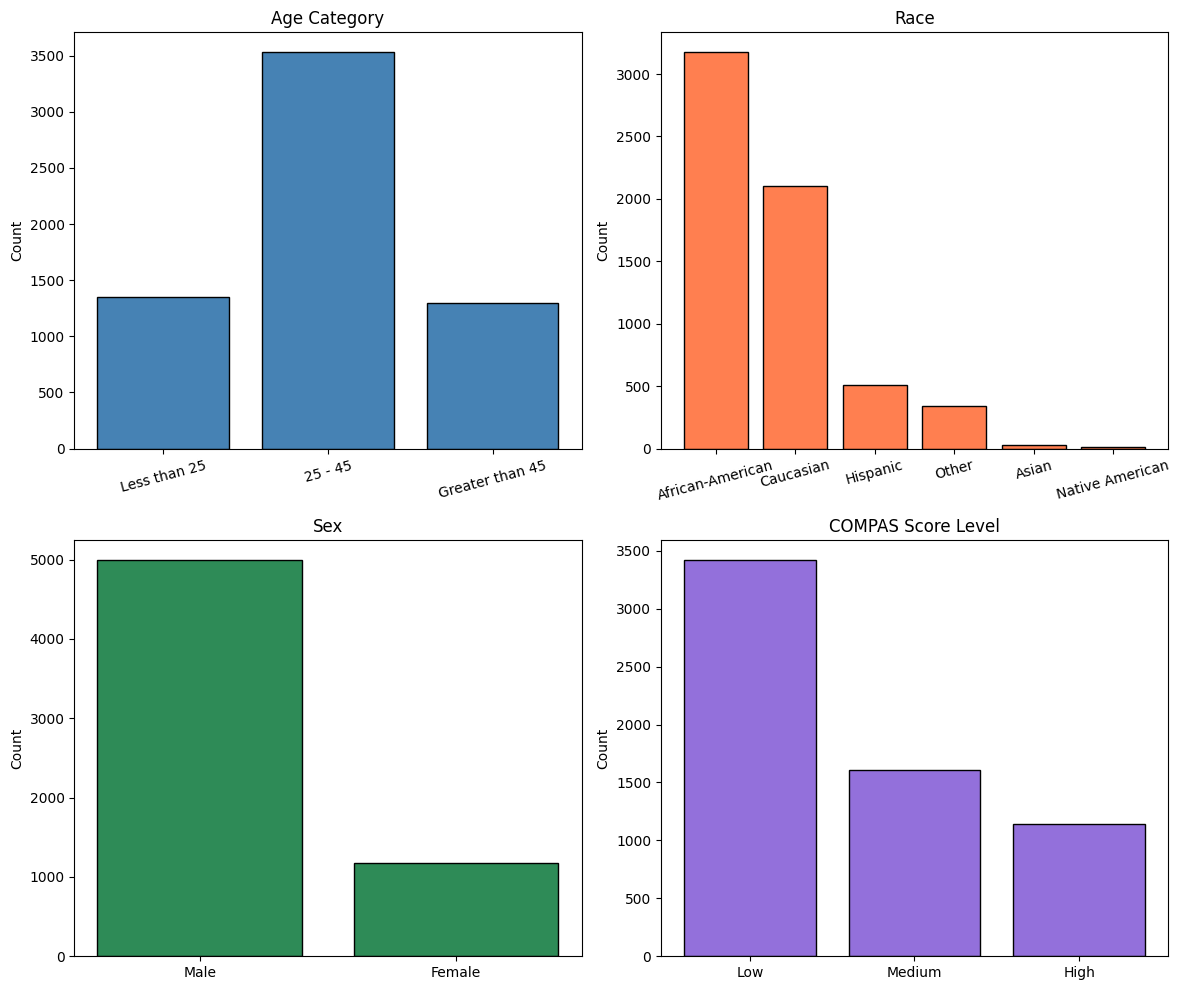

In [12]:
# Bar charts: demographics by age category, race, sex; COMPAS score distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Age category
age_counts = df["age_cat"].value_counts().reindex(["Less than 25", "25 - 45", "Greater than 45"])
axes[0, 0].bar(age_counts.index, age_counts.values, color="steelblue", edgecolor="black")
axes[0, 0].set_title("Age Category")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=15)

# Race
race_counts = df["race"].value_counts()
axes[0, 1].bar(race_counts.index, race_counts.values, color="coral", edgecolor="black")
axes[0, 1].set_title("Race")
axes[0, 1].set_ylabel("Count")
axes[0, 1].tick_params(axis="x", rotation=15)

# Sex
sex_counts = df["sex"].value_counts()
axes[1, 0].bar(sex_counts.index, sex_counts.values, color="seagreen", edgecolor="black")
axes[1, 0].set_title("Sex")
axes[1, 0].set_ylabel("Count")

# COMPAS score (Low / Medium / High)
score_counts = df["score_text"].value_counts().reindex(["Low", "Medium", "High"])
axes[1, 1].bar(score_counts.index, score_counts.values, color="mediumpurple", edgecolor="black")
axes[1, 1].set_title("COMPAS Score Level")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

/var/folders/d9/cgypymwn2tj96mmjdmrs_2xr0000gn/T/ipykernel_3815/1146596052.py:6: Pandas4Warning: The copy keyword is deprecated and will be removed in a future version. Copy-on-Write is active in pandas since 3.0 which utilizes a lazy copy mechanism that defers copies until necessary. Use .copy() to make an eager copy if necessary.
  cross.plot(kind="bar", figsize=(10, 5), color=["#2ecc71", "#f39c12", "#e74c3c"], edgecolor="black")


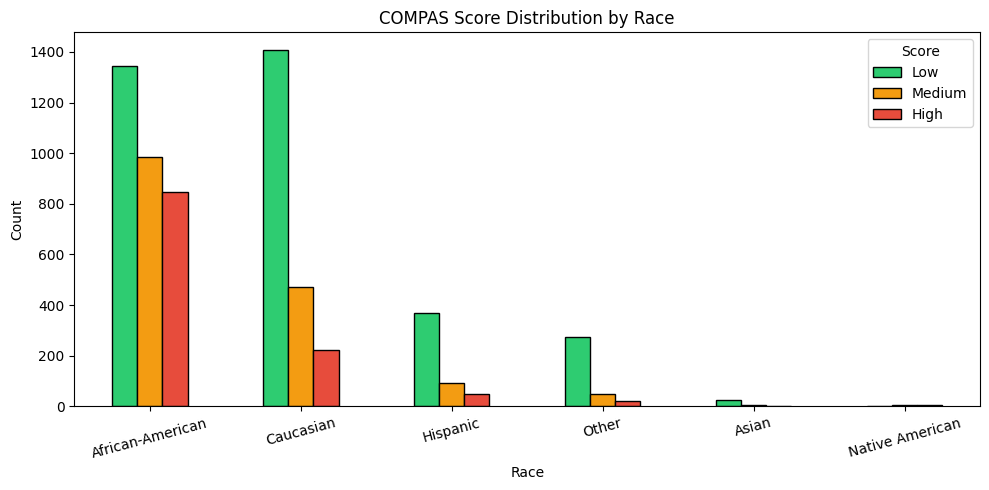

In [16]:
# Score distribution by race: Low/Medium/High counts (all races)
races_main = df["race"].value_counts().index.tolist()
score_order = ["Low", "Medium", "High"]

cross = pd.crosstab(df["race"], df["score_text"]).reindex(columns=score_order).loc[races_main]
cross.plot(kind="bar", figsize=(10, 5), color=["#2ecc71", "#f39c12", "#e74c3c"], edgecolor="black")
plt.title("COMPAS Score Distribution by Race")
plt.xlabel("Race")
plt.ylabel("Count")
plt.legend(title="Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

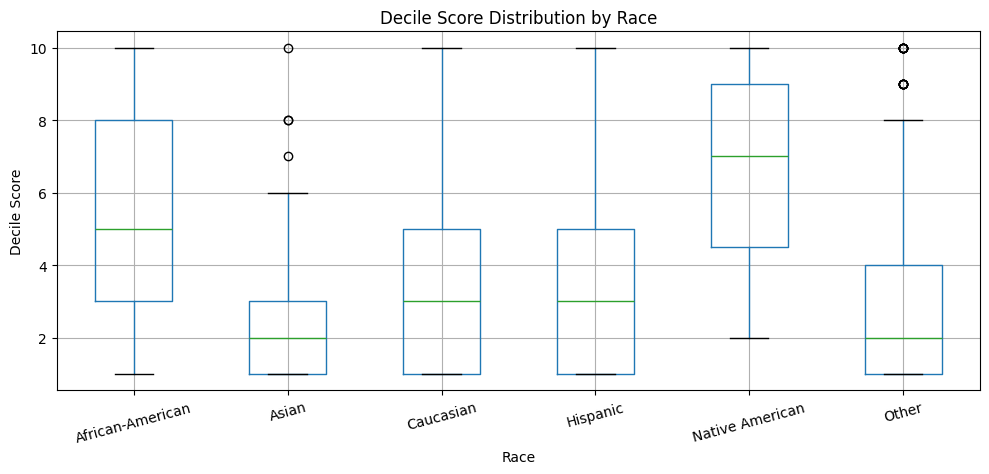

In [17]:
# Decile score distribution by race (box plot)
df_races = df[df["race"].isin(races_main)]
df_races.boxplot(column="decile_score", by="race", figsize=(10, 5))
plt.suptitle("")
plt.title("Decile Score Distribution by Race")
plt.xlabel("Race")
plt.ylabel("Decile Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

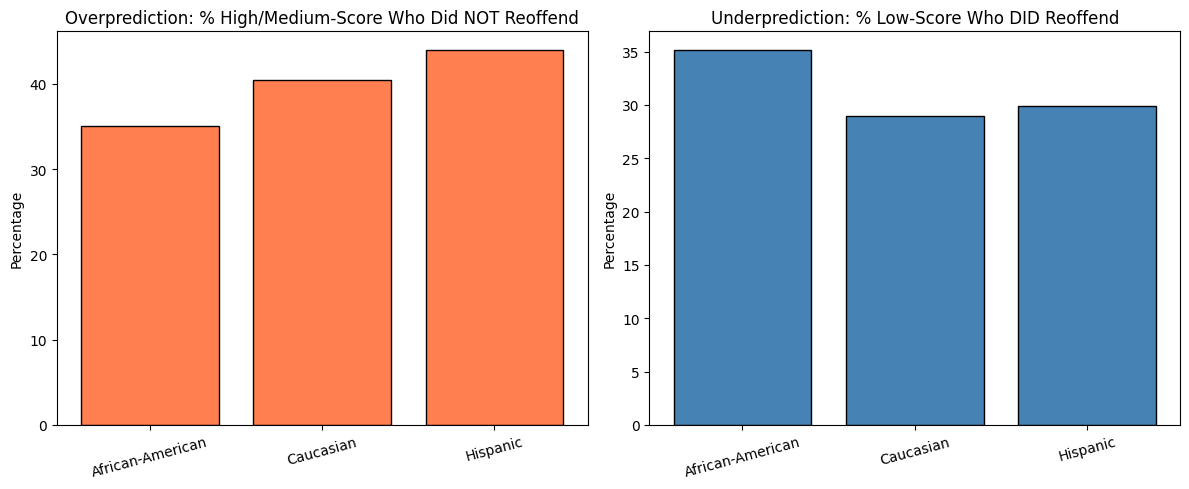

In [15]:
# Directions of bias by race
overpred_pct = []
underpred_pct = []
for r in races_main:
    sub = df[df["race"] == r]
    high_sub = sub[sub["score_text"].isin(["Medium", "High"])]
    low_sub = sub[sub["score_text"] == "Low"]
    n_high = len(high_sub)
    n_low = len(low_sub)
    overpred_pct.append(100 * len(high_sub[high_sub["two_year_recid"] == 0]) / n_high if n_high > 0 else 0)
    underpred_pct.append(100 * len(low_sub[low_sub["two_year_recid"] == 1]) / n_low if n_low > 0 else 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(races_main, overpred_pct, color="coral", edgecolor="black")
axes[0].set_title("Overprediction: % High/Medium-Score Who Did NOT Reoffend")
axes[0].set_ylabel("Percentage")
axes[0].tick_params(axis="x", rotation=15)

axes[1].bar(races_main, underpred_pct, color="steelblue", edgecolor="black")
axes[1].set_title("Underprediction: % Low-Score Who DID Reoffend")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis="x", rotation=15)

plt.tight_layout()
plt.show()

# 6.4 Pipeline: Design Focus

Different stakeholders use different definitions of fairness. I contrast Kleinberg, Mullainathan, and Raghavan's "Inherent Trade-Offs in the Fair Determination of Risk Scores" with ProPublica.

Confidence: 8

## ProPublica's Fairness Definition

ProPublica's "Machine Bias" analysis emphasized **disparities in error rates** between Black and white defendants. Specifically, they found that (1) Black defendants were more likely to be incorrectly labeled as higher risk (false positives / overprediction), and (2) white defendants were more likely to be incorrectly labeled as lower risk (false negatives / underprediction). For ProPublica, fairness means **balance for the positive and negative classes**: people who do not reoffend should receive similar scores across groups, and people who do reoffend should receive similar scores across groups. When base rates of recidivism differ by race, satisfying this notion of fairness becomes the central concern.

## Kleinberg et al.'s Framework

Kleinberg, Mullainathan, and Raghavan formalize three fairness conditions:

- **(A) Calibration within groups**: Among people assigned score z, approximately a z fraction should be positive instances, and this should hold separately for each group. (This is what Northpointe defended—COMPAS is well-calibrated.)

- **(B) Balance for the negative class**: The average score given to people who do NOT reoffend should be the same across groups. (ProPublica's overprediction concern.)

- **(C) Balance for the positive class**: The average score given to people who DO reoffend should be the same across groups. (ProPublica's underprediction concern.)

Their main result: **These three conditions are mathematically incompatible** except in two narrow cases—(1) perfect prediction, or (2) equal base rates across groups. When Black and white defendants have different recidivism rates (different base rates), no risk assignment can satisfy calibration (A) and both balance conditions (B) and (C) at once. ProPublica focused on (B) and (C); Northpointe focused on (A). The conflict is not merely empirical—it is inherent to the definitions.

## Why There Is a Conflict

The conflict arises because the conditions impose different constraints on the same risk scores. Calibration says "scores should mean what they claim" within each group. Balance says "people with the same true outcome should get similar scores" across groups. When base rates differ, these pull in opposite directions. Satisfying one set of conditions forces violation of the other. Kleinberg et al. do not endorse any single definition; they show that **any** risk score can be criticized on some natural notion of fairness, and that the choice of which fairness definition to prioritize is a value judgment, not a technical one.

## My View: What Should Matter Most

When deciding whether to use a tool like COMPAS, I believe **transparency** should matter most. As Rudin et al. argue, without transparency we cannot verify which fairness conditions a model satisfies, whether it depends on age or race in problematic ways, or whether calculation errors occur. Different stakeholders will reasonably disagree on which fairness definition to prioritize (calibration vs. error-rate parity). That debate is legitimate and should happen in the open. But it cannot happen meaningfully if the model is proprietary and its logic is opaque. Transparency enables scrutiny, correction of errors, and informed debate about which trade-offs are acceptable. I would prioritize transparency over any single fairness definition, and favor interpretable, auditable alternatives to proprietary black boxes when they achieve comparable accuracy.

# 6.5 Pipeline: Press Release (confidence 8)

Role-play: Member of the Albemarle County Board of Supervisors. The board must take a public position on the use of algorithmic risk-assessment tools in pretrial decision making.

Confidence: 8

---

**FOR IMMEDIATE RELEASE**

**Albemarle County Board of Supervisors Prioritizes Transparency in Pretrial Risk Assessment**

*Board Opposes Proprietary Tools; Supports Interpretable, Auditable Alternatives*

CHARLOTTESVILLE, Va.—The Albemarle County Board of Supervisors today announced its position on the use of algorithmic risk-assessment tools in pretrial decision making. The board prioritizes **transparency** over any single definition of fairness. Without transparency, the public cannot verify whether a tool satisfies calibration, error-rate parity, or other fairness criteria—or whether it relies on age, race, or other protected characteristics in problematic ways. The board opposes the adoption of proprietary, black-box risk scores and supports interpretable, auditable alternatives when they achieve comparable accuracy.

Independent analysis of publicly available COMPAS data illustrates why transparency matters. As shown in Figure 1, third-party researchers can quantify overprediction and underprediction by race only when the underlying data and methodology are accessible. Such scrutiny is impossible with proprietary tools. The board believes that informed debate about which fairness trade-offs are acceptable cannot occur if the model’s logic remains opaque. Transparency enables correction of errors, accountability, and meaningful public input. The board will not support the use of algorithmic risk-assessment tools in pretrial decisions unless their design, data, and methodology are open to verification.

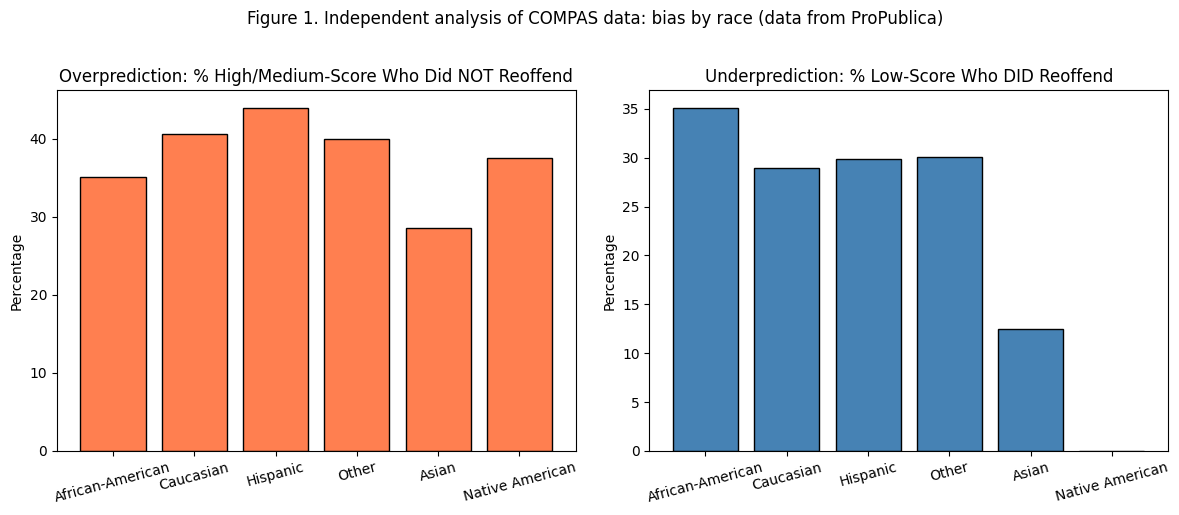

In [18]:
# Figure 1: Directions of bias by race (supports transparency argument—independent analysis possible only with public data)
races_main = df["race"].value_counts().index.tolist()
overpred_pct = []
underpred_pct = []
for r in races_main:
    sub = df[df["race"] == r]
    high_sub = sub[sub["score_text"].isin(["Medium", "High"])]
    low_sub = sub[sub["score_text"] == "Low"]
    n_high = len(high_sub)
    n_low = len(low_sub)
    overpred_pct.append(100 * len(high_sub[high_sub["two_year_recid"] == 0]) / n_high if n_high > 0 else 0)
    underpred_pct.append(100 * len(low_sub[low_sub["two_year_recid"] == 1]) / n_low if n_low > 0 else 0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(races_main, overpred_pct, color="coral", edgecolor="black")
axes[0].set_title("Overprediction: % High/Medium-Score Who Did NOT Reoffend")
axes[0].set_ylabel("Percentage")
axes[0].tick_params(axis="x", rotation=15)
axes[1].bar(races_main, underpred_pct, color="steelblue", edgecolor="black")
axes[1].set_title("Underprediction: % Low-Score Who DID Reoffend")
axes[1].set_ylabel("Percentage")
axes[1].tick_params(axis="x", rotation=15)
plt.suptitle("Figure 1. Independent analysis of COMPAS data: bias by race (data from ProPublica)", y=1.02)
plt.tight_layout()
plt.show()

# 6.6 Apply in New Context

Apply principles of soft metadata (provenance, licensing, ethical considerations) to a new data journalism article.

Confidence: 8

## Article

**ProPublica, "Texas Banned Abortion. Then Sepsis Rates Soared."** (February 2025)  
https://www.propublica.org/article/texas-abortion-ban-sepsis-maternal-mortality-analysis

ProPublica analyzed Texas hospital discharge data to show that sepsis rates in second-trimester pregnancy-loss hospitalizations increased by more than 50% after Texas's near-total abortion ban took effect in September 2021.

## Provenance

ProPublica clearly documents the **origin** of the data. They purchased seven years (2017–2023) of Texas inpatient hospital discharge records from the Texas Department of State Health Services. The methodology article links to the [Texas inpatient public-use data file](https://www.dshs.texas.gov/center-health-statistics/texas-health-care-information-collection/health-data-researcher-information/texas-hospital-emergency-department-research-data-file-ed-rdf/texas-inpatient-public-use-data-file-pudf) and the [data dictionary](https://www.dshs.texas.gov/sites/default/files/thcic/hospitals/InpatientDataDictionary2Q2024.pdf). They explain that they adapted the federal methodology developed by HRSA, CDC, AHRQ, and the Alliance for Innovation on Maternal Health—and link to the HRSA statistical code. They consulted dozens of researchers and clinicians to adapt the algorithm for pregnancy-loss complications. The provenance chain (data source → transformation → analysis) is explicit and traceable.

## Licensing

The **analysis code** is released under the MIT license on GitHub, allowing reuse and modification. The **data** itself is not included in the repository; it must be purchased from the Texas Department of State Health Services. ProPublica states this clearly in the README and methodology, so readers know what they can and cannot reproduce without additional data access.

## Ethical Considerations

ProPublica addresses **ethical concerns** directly. The data are de-identified, and the analysis focuses on aggregate rates rather than individual patients. The methodology article discusses limitations: discharge data cannot isolate coding changes from outcome changes; it cannot capture outpatient care; double-counting across hospital transfers may occur; and the dataset does not reveal when patients were turned away. They note that more than a dozen maternal health experts reviewed the findings. The sensitivity of pregnancy loss and maternal mortality is acknowledged, and the analysis is framed as filling a gap left when neither the CDC nor states investigate deaths related to abortion bans.

## GitHub Reproducibility Assessment

ProPublica's GitHub repository (https://github.com/propublica/tx-pregnancy-loss-sepsis-analysis) supports reproducibility well in several ways: the README links to the main article and the methodology; the analysis is organized into clear steps (Step 1: code pregnancy ends; Step 2: analyze outcomes) with Jupyter notebooks; and the project uses Poetry for dependency management with `pyproject.toml` and `poetry.lock`. However, reproducibility is **partial**. The raw data are not shared—readers must purchase them from Texas DSHS—and the initial data-processing step (combining and transforming tab-delimited files, loading into PostgreSQL) is not included because it is "bespoke to the format of the raw data." As a result, a researcher can reproduce the analytical logic and verify the coding and statistical steps, but cannot fully re-run the pipeline from raw data without obtaining and processing the data independently. The methodology article and code together provide strong transparency, but full reproducibility would require either sharing the processed data or documenting the preprocessing step in more detail.

# 6.7 Review: Definitions

Provide definitions, or describe the distinction, for the following (one or two sentences each).

Confidence: 8

## 6.7.1 Accuracy vs. Precision

**Accuracy** is how close a measurement or estimate is to the true value. **Precision** is how consistent or repeatable measurements are—how close repeated measurements are to each other. A measurement can be precise but inaccurate (high consistency, low correctness) or accurate but imprecise (correct on average, but with high variability).

## 6.7.2 Seed

A **seed** is a value used to initialize a pseudorandom number generator. When a generator is seeded with the same value, it produces the same sequence of "random" numbers, which enables reproducibility of experiments and simulations that depend on randomness.

## 6.7.3 Stratified Sampling

**Stratified sampling** divides the population into groups (strata) based on a shared characteristic, then draws a random sample from each stratum. This ensures that subgroups are represented in proportion to their size in the population and can reduce sampling error compared to simple random sampling.

## 6.7.4 Schema

A **schema** is the structure or blueprint of a database—it defines the tables, columns, data types, constraints, and relationships. It describes how data is organized and what rules govern it, without containing the actual data values.

## 6.7.5 Primary Key vs. Foreign Key

A **primary key** uniquely identifies each row in a table and cannot be null or duplicated. A **foreign key** is a column (or set of columns) in one table that references the primary key of another table, establishing a relationship between tables and enforcing referential integrity.

## 6.7.6 Relational Algebra

**Relational algebra** is a formal system of operations for manipulating relations (tables) in a relational database. It includes operations such as selection, projection, join, union, intersection, and difference, which form the theoretical foundation for SQL query languages.

## 6.7.7 Metadata

**Metadata** is data that describes other data—it provides information about the content, structure, origin, format, or usage of a dataset. Examples include column names, data types, creation dates, provenance, and licensing terms.

## 6.7.8 Provenance vs. DMP

**Provenance** refers to the origin, history, and lineage of data—where it came from, how it was collected, transformed, or derived, and who created it. A **Data Management Plan (DMP)** is a formal document that describes how data will be collected, stored, shared, and preserved over the lifecycle of a project; it may include provenance but is broader and forward-looking.

## 6.7.9 Representative Sample

A **representative sample** is a subset of a population that reflects the key characteristics of the population (e.g., demographics, distributions, proportions). When a sample is representative, inferences drawn from it can be generalized to the population with greater validity.

## 6.7.10 FAIR vs. CARE

**FAIR** (Findable, Accessible, Interoperable, Reusable) emphasizes making data and metadata machine-readable and usable by researchers and systems—focusing on data as a resource. **CARE** (Collective Benefit, Authority to Control, Responsibility, Ethics) emphasizes the rights and interests of Indigenous peoples and communities whose data are used—focusing on data governance and equity. FAIR is data-centric; CARE is people- and community-centric.

# 6.8 Review: Multiple Choice

Confidence: 9

6.8.1: (B)

6.8.2: (C)

6.8.3: (C)

6.8.4: (B)

6.8.5: (D)

6.8.6: (C)

6.8.7: (A)

6.8.8: (B)

6.8.9: (A)

6.8.10: (D)